In [2]:
import yfinance as yf
import statsmodels 
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import nasdaqdatalink as ndl
plt.style.use('seaborn-darkgrid')

/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_39682/2700784245.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [3]:
ticker = 'SPY'
spy = yf.download(ticker, start = '2014-01-01' , end ='2019-12-31')
spy = pd.DataFrame(spy)
spy['Return'] = spy['Adj Close'].pct_change()
effr = ndl.get("FRED/DFF", start_date = '2014-01-01' , end_date ='2019-12-31')
spy['Excess Return'] = spy['Return'] - (effr['Value']/(100*252))
spy['Daily interest rate'] = effr['Value']/(100*252)


[*********************100%***********************]  1 of 1 completed


In [4]:
train_set_len = int(len(spy)*0.7)
spy_train = spy[:train_set_len]
spy_test = spy[train_set_len:]


/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_39682/4179501135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = leverage
/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_39682/4179501135.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Strategy Return'] = df['Signal'].shift(1) * df['Excess Return']
/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_39682/4179501135.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

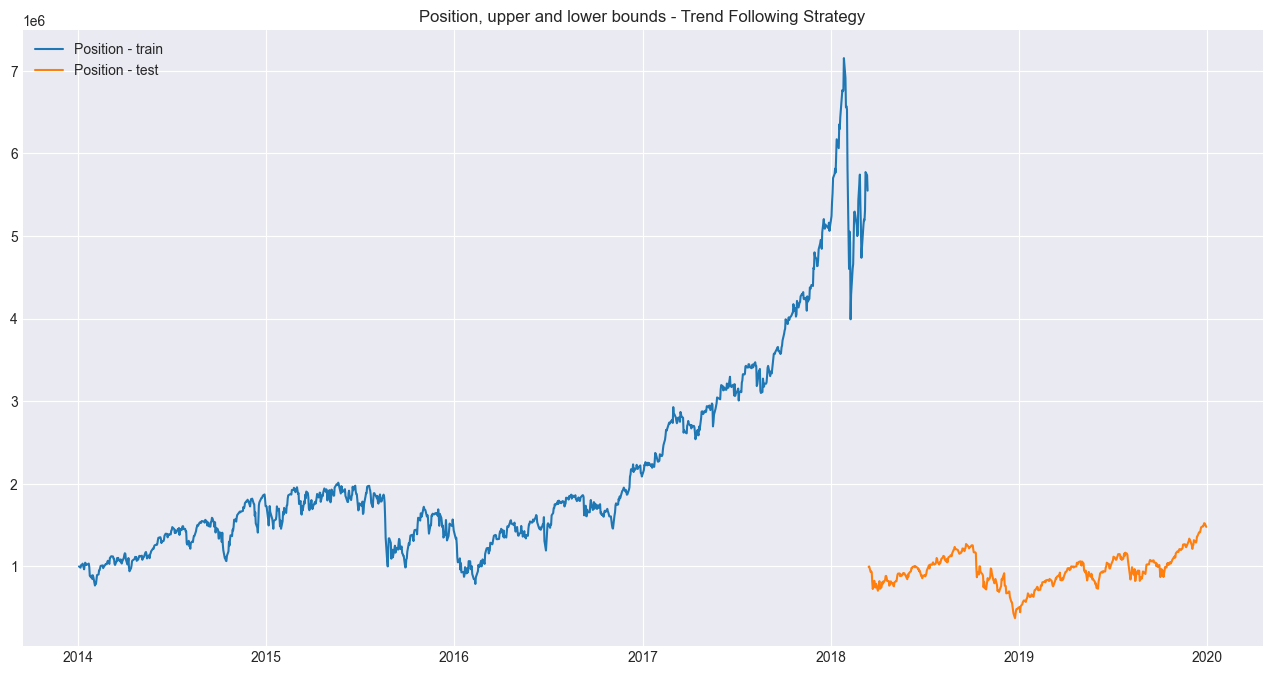

In [5]:
def buy_n_hold(df, leverage, initial_cap):
    df['Signal'] = leverage
    df['Strategy Return'] = df['Signal'].shift(1) * df['Excess Return']
    df['Cash'] = (1+df['Strategy Return']).cumprod() * initial_cap
    df['PnL'] = df['Cash'].diff()
    return df

spy_train = buy_n_hold(spy_train, 5, 200000)
spy_test = buy_n_hold(spy_test, 5, 200000)

plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('Position, upper and lower bounds - Trend Following Strategy')
#plt.plot(spy_train['Cash']*5, label= 'Upper bound - train')
plt.plot(spy_train['Cash']*spy_train['Signal'], label= 'Position - train')
#plt.plot(spy_train['Cash']*-5, label= 'Lower bound - train')
#plt.plot(spy_test['Cash']*5, label  = 'Upper bound - test')
plt.plot(spy_test['Cash']*spy_test['Signal'], label= 'Position - test')
#plt.plot(spy_test['Cash']*-5, label= 'Lower bound - test')
plt.legend(loc='upper left')

In [6]:
# compute the Sharpe ratio

def annualised_sharpe_ratio(df):
    return (df['Strategy Return'].mean()*252)/(df['Strategy Return'].std()*np.sqrt(252))

print(annualised_sharpe_ratio(spy_train))
print(annualised_sharpe_ratio(spy_test))

# compute the sortino ratio

def annualised_sortino_ratio(df):
    return (df['Strategy Return'].mean()*252)/(df['Strategy Return'][df['Strategy Return']<0].std()*np.sqrt(252))

print(annualised_sortino_ratio(spy_train))
print(annualised_sortino_ratio(spy_test))

# compute the max drawdown

def max_drawdown(df):
    comp_ret = (df['Strategy Return']+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

print(max_drawdown(spy_train))
print(max_drawdown(spy_test))
# compute the calmar ratio

def calmar_ratio(df):
    return (df['Strategy Return'].mean()*252)/abs(max_drawdown(df))

print(calmar_ratio(spy_train))
print(calmar_ratio(spy_test))

0.9747479398514142
0.6671233513679558
1.216716555175384
0.8281129593159392
-0.6089276093113805
-0.7062571460314742
0.9961579203943872
0.6839054906711859


In [7]:
print(spy_test['Strategy Return'].mean(), spy_test['Strategy Return'].std())

0.0019167188095106616 0.045609208187419294
